In [2]:
import numpy as np
import collections
import math
from sklearn.preprocessing import normalize
import time
import pickle
import tweepy

# open file

In [5]:
with open('followees_list.pickle','rb') as f:
    collection = pickle.load(f)

In [84]:
N_documents = len(collection)

# ----------------setting ---------------
k_topics = 6
ll = 0.9 # lambda
seed = 0

# build vocabulary

<p> all the unique words in the whole collection </p>

In [85]:
def build_vocab(col):
    
    vocab = {}     # word: counts

    for doc in col:
        unique_words_d = collections.Counter(doc)

        for w in unique_words_d.keys():
            if w not in vocab.keys():
                vocab[w] = unique_words_d[w]
            else:
                vocab[w] += unique_words_d[w]
    
    return vocab

In [86]:
vocab = build_vocab(collection)
n_words = len(vocab)

In [87]:
n_words

121976

# build background distribution p(w|D)
<img src=pwd.png>

In [88]:
def build_background(voc):
    # p(w|D) = sum(c(w,Di))/sum(sum(c(wi,Di)))  
    # background distribution of a word is fixed

    p_w_D = {}
    total_counts = sum(voc.values())

    for w in voc.keys():
        p_w_D[w] = voc[w]/total_counts
        
    return p_w_D

In [89]:
p_w_D = build_background(vocab)

In [90]:
list(p_w_D.keys())[:5]
p_w_D[2229272575]

1.3295308750307455e-05

# Calculate word count in each document c(w,d)

In [91]:
def cal_word_doc(i_col,i_voc):
    # c(w,d)
    c_w_d = []

    for doc in i_col:
        c_w = collections.Counter(doc)
        c_w_d.append(c_w)
    
    return c_w_d

In [92]:
c_w_d = cal_word_doc(collection,vocab)

# E step

In [93]:
def initial(vocab, N_documents, k_topics, seed):
    
    # guess p(z= k|pi) and p(w|theta)
    
    
    np.random.seed(seed)
    norm_pi_0 = normalize(np.random.rand(N_documents, k_topics),norm='l1')   # k topic, N document
    theta_array = normalize(np.random.rand(n_words,k_topics),norm='l1',axis = 0)    # n words, k topics
    
    i=0
    norm_theta_0 = {}
    
    for word in vocab.keys():
        norm_theta_0[word] = theta_array[i]
        i=i+1
           
    return norm_pi_0, norm_theta_0

# build Q function
<img src="qfunc.png"> 
<img src="EM_sum.png"> 

In [94]:
# for a given document and given word, sum over all the topics
# optimize: only caculate for the word doc pair within c(w,d) to avoid memory problem

def build_q_func(pi, theta, p_w_D, ll):
       
    sum_q = np.dot(pi,theta) # (top1, top2 ...) * (top1, top2 ....)T
    q_func = ((1-ll)* np.multiply(pi, theta))/(ll* p_w_D + (1-ll)*sum_q)
    
    return q_func

# build N 
<img src="EM_ndk.png"> 
<img src="EM_n.png"> 

In [95]:
def build_n(pi, theta, ll, N_documents,k_topics,c_w_d, p_w_D):
    
    n_d_k = np.empty((N_documents,k_topics))
    n_w_k = {}
    
    for d in range(N_documents):

        SUM = np.empty((k_topics,))

        for w in c_w_d[d].keys():              
            q_func = build_q_func(pi[d], theta[w], p_w_D[w], ll)           
            SUM += c_w_d[d][w] * q_func
            
            if w not in n_w_k.keys():
                n_w_k[w] = c_w_d[d][w] * q_func
            else:
                n_w_k[w] = np.add(n_w_k[w],c_w_d[d][w] * q_func)    
    
        n_d_k[d] = SUM
        
    return n_d_k, n_w_k  

# M step
<img src="mstep.png"> 

In [96]:
def build_pi_theta(N_documents, k_topics, vocab, n_d_k, n_w_k):      
    
    pi_n = np.empty((N_documents,k_topics))
    for d in range(N_documents):
        pi_n[d] = n_d_k[d]/np.sum(n_d_k[d])

    theta_n = {}
    SUM = np.empty((k_topics,))
    
    for w in vocab.keys():
        SUM += n_w_k[w]
        
    for w in vocab.keys():            
        theta_n[w] = np.divide(n_w_k[w], SUM)
        
        
    return pi_n, theta_n

In [97]:
# test block: Make sure all of your distributions sum to 1 at all times! Remember that your π distributions will sum to 1 across the KK topics (excluding the background) and that your \theta_kθ
# k toipcs, theta distributions will sum to 1 across the entire vocabulary V

def test_distribution(pi_n, theta_n, N_documents, k_topics, vocab):
    
    for d in range(N_documents):
        
        if abs(np.sum(pi_n[d]) - 1) > 0.0001:
            print(pi_n[d])
            print(d,'document has problem over pi distribution')
    
    for k in range(k_topics):
        
        SUM = 0    
        for w in vocab.keys():
            SUM += theta_n[w][k]          
        if abs(SUM -1) > 0.0001:
            print(SUM, k,'topic has problem over theta distribution')
            
    return None

# log function
<img src= log.png>

In [98]:
def log_function(N_documents,c_w_d,p_w_d,pi,theta):
    
    log_func = 0
    for d in range(N_documents):
        
        for word in c_w_d[d].keys():
            
            sum_q = np.dot(pi[d], theta[word])
            log_func += c_w_d[d][word]*math.log2(ll*p_w_D[word] + (1-ll)*sum_q)
            
    return log_func

# EM algorithm 

In [99]:
def EM_algorithm(N_documents, k_topics, vocab, ll,c_w_d, p_w_D, iter_times,seed):
     
    pi_0, theta_0 =initial(vocab, N_documents, k_topics, seed)
    n_dk, n_wk = build_n(pi_0, theta_0, ll, N_documents, k_topics, c_w_d, p_w_D)
    pi_n, theta_n = build_pi_theta(N_documents,k_topics, vocab, n_dk, n_wk)
    
    #------------test distribution-------------------------------
    test_distribution(pi_n,theta_n,N_documents,k_topics,vocab)
    
    
    #------------iteraetion starts--------------------------------
    iter_n = 0
    log = [log_function(N_documents,c_w_d,p_w_D,pi_0,theta_0)]  
    rel_change = []
    
    while (iter_n != iter_times):
        
        start = time.clock()
        
        n_dk, n_wk = build_n(pi_n, theta_n, ll, N_documents, k_topics, c_w_d, p_w_D)
        pi_n, theta_n = build_pi_theta(N_documents,k_topics, vocab, n_dk, n_wk)

        #------------test distribution-------------------------------
        test_distribution(pi_n,theta_n,N_documents,k_topics,vocab)


        #------------- log function ----------------------------------          
        log_func = log_function(N_documents,c_w_d,p_w_D,pi_n,theta_n)

        rel = (log[-1]-log_func)/log[-1]
        log.append(log_func)
        rel_change.append(rel)
        
        print('log_func:',log_func)
        print('relative change:', rel)
        
        if rel <=0.00001:
            break
        
        iter_n += 1
        
        end = time.clock()
        print('---------------------------------')    
        print('iteration:',iter_n, 'time:',end-start,'sec\n')
        
    return pi_n, theta_n, log,rel_change

In [100]:
pi_n, theta_n, log, rel_change = EM_algorithm(N_documents,k_topics, vocab, ll, c_w_d, p_w_D, 100, seed)

log_func: -2492330.1474430626
relative change: 0.005578115968190823
---------------------------------
iteration: 1 time: 8.492876445077854 sec

log_func: -2479373.5739459465
relative change: 0.005198578330566895
---------------------------------
iteration: 2 time: 4.458108621864085 sec

log_func: -2463915.797818131
relative change: 0.006234549037003131
---------------------------------
iteration: 3 time: 3.0389891415770762 sec

log_func: -2450491.6791645093
relative change: 0.005448286287018806
---------------------------------
iteration: 4 time: 3.2386727672155757 sec

log_func: -2441344.412640584
relative change: 0.003732829048839646
---------------------------------
iteration: 5 time: 3.0975680057345016 sec

log_func: -2435879.1671897257
relative change: 0.0022386212377741594
---------------------------------
iteration: 6 time: 3.055129878988737 sec

log_func: -2432398.186944762
relative change: 0.0014290447128294558
---------------------------------
iteration: 7 time: 3.06963828206

In [101]:
with open('RUN_'+str(seed)+'_pi_n.pickle','wb+') as f:
    pickle.dump(pi_n, f)
with open('RUN_'+str(seed)+'_theta_n.pickle','wb+') as f:
    pickle.dump(theta_n, f)
with open('RUN_'+str(seed)+'_log.pickle','wb+') as f:
    pickle.dump(log, f)

# print the top 10 words in each topic

In [102]:
consumer_key = 'mVJcyNN5qFyk7GdBJvENVc329'
consumer_secret = 'DbXUXB7EN77HmzQahobHeTPSWgcNI9t8kKzDoe5twfTORnjXxf'
access_token = '707770026573561856-Vfqm0iXrsBvFL2prQMQ2Gzu9eawWYIj'
access_token_secret = 'HSMqS4YkDBcB6mm9JL3vd6VeKlkKmNdMxmJ0inJQwNhXS'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit= True,wait_on_rate_limit_notify=True)

In [103]:
top_20_followees = []

In [109]:
for k in range(4,5):
    
    topic = {}
    for word in vocab.keys():
        topic[word] = theta_n[word][k]

    ranked_list = sorted(topic.items(), key=lambda x: x[1],reverse=True)[:20]
    temp = [(api.get_user(str(r[0])).screen_name,api.get_user(str(r[0])).location) for r in ranked_list]
    
    top_20_followees.append(temp)

In [4]:
with open ('top_20_followee.pickle','rb+') as f:
    top_20_followee.picklepickle.load(f)

NameError: name 'top_20_followees' is not defined

In [130]:
for k in range(5):
    for ff in top_20_followees[k][:10]:
        print(ff)
    print('\n')

('AngelaWoody', 'Chicago')
('ThreeGuySports', '')
('ChiCitySports23', 'Chicago')
('NiseiLounge', '3439 N Sheffield Ave, Chicago')
('flo_ottis', 'Chicagoland')
('PayneTrainsIL', 'Chicago, IL')
('markhoppus', 'Stage Right')
('AstronomerJoe', 'Chicago, Illinois')
('cameronesposito', 'Los Angeles, CA')
('jcrew', '')


('CommsUnited', 'Chicago, IL')
('Judd_Sirott', '')
('NaomiAKlein', '')
('Carrie_Rachel', 'worldwide')
('11thWardChicago', 'South Side of Chicago')
('evanstonspace', 'Evanston, Illinois')
('JoeBudden', 'IG: JoeBudden')
('portlandia', '')
('factcheckdotorg', 'Philadelphia')
('seanonolennon', 'New York, NY')


('JonnyCampbell16', 'Chicago, IL')
('sjohn25', 'Chicago')
('thesoccerdon', '')
('EvervilleFans', 'Honolulu, HI')
('1Hainty', '')
('_Phli', 'southside, IL')
('XavierWoodsPhD', 'Atlanta, GA')
('glasses26', '')
('Trevornoah', 'New York, NY')
('TalentCulture', 'Cambridge, MA ')


('BreneBrown', 'University of Houston')
('SkydeckChicago', 'Chicago, Ill.')
('Jenna_Marbles', 'Sir

In [131]:
pi_n[1]

array([  5.55398601e-52,   2.42586887e-08,   9.99999976e-01,
         1.91023711e-40,   3.00107715e-36,   6.28744096e-38])

In [64]:
# plot

%matplotlib inline
import matplotlib.pyplot as plt

def plot_2D(x,y,x_label, y_label, title):
    
    plt.plot(x,y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    
    plt.show()
    
    
    return None

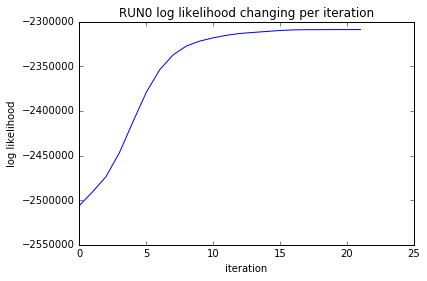

In [65]:
plot_2D(range(len(log)), log, 'iteration', 'log likelihood', 'RUN'+str(seed)+' log likelihood changing per iteration')

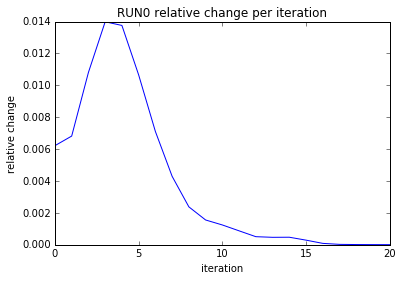

In [66]:
plot_2D(range(len(rel_change)), rel_change, 'iteration', 'relative change', 'RUN'+str(seed)+' relative change per iteration')